# Drizzle 2: Bayer drizzle

Drizzle separately each of the R, G, and B arrays of a Bayer image. 

At the end, combine the resulting 3 arrays as a 3-extension FITS file. 

It is assujed the input was already background-subtracted.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use the ISO 6400 data set. Statements specific to the original data set were comented out.

In [1]:
# %matplotlib ipympl

import os, glob
import datetime

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from drizzle import cdrizzle
import rawpy

from datapath import DATA

# IMAGE_SUFFIX = ".cutout.fits"         # 135 mm
IMAGE_SUFFIX = ".bkg_subtracted.fits"   # 85 mm
# IMAGE_SUFFIX = ".ARW"   # 85 mm

# for background subtraction experiment
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground, ModeEstimatorBackground

/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26190/2611111415.py:24: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26190/2611111415.py:24: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26190/2611111415.py:24: DeprecationWarning: `photutils.ModeEstimatorBackground` is a deprecated alias for `photutils.background.ModeE

## Functions

In [2]:
# input images can be either ARW or FITS (tipically, background-subtracted)

def _read_fits_image(image_name):
    f = fits.open(image_name)
    imarray = f[1].data
    f.close()
    return imarray

def _read_arw_image(image_name):
    raw = rawpy.imread(image_name)
    return raw.raw_image_visible.astype(float)

read_function = {
    "FITS": _read_fits_image,
    "ARW":  _read_arw_image
}

def read_image(image_name):
    return read_function[image_name.split('.')[-1].upper()](image_name)

In [3]:
def drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context, 
              aslice=None):
    # for diagnostic purposes, this function will also return stats associated 
    # with each one of the input RGB arrays
    stats = []
    
    # loop over the RGB bands    
    for band in list(range(3)):
        
        # generate zeroed array and add the input rawpy array to it. This is necessary 
        # since calling cdrizzle.tdriz directly with the rawpy-generated array as input,
        # causes an exception to be raised by cdrizzle. 
        # 
        # We also need to apply the mask/weights here, because drizzle will re-scale 
        # the mask when doing pixel re-scaling.
        imarray_copy = np.zeros(imarray.shape, dtype='float32')
        imarray_copy += imarray * weights[band]

        # stats for diagnostics
        imarray_stats = imarray_copy
        imarray_stats[imarray_copy == 0.] = np.NaN
        stats.append(np.nanmean(imarray_stats[aslice]))
        
        # call C core drizzle algorithm
        cdrizzle.tdriz(imarray_copy, weights[band], pixmap, output_array[band], 
                       output_counts[band], output_context[band], 
                       kernel="turbo", expscale=1.)
        
    return stats

In [4]:
def drizz(filename, output_array, weights, output_counts, output_context):
    '''
    Drizzle one raw image. 
    
    This works by breaking up the raw array into each one of its 3 sub-images,
    R, G, and B, and drizzling them separately into their own respective
    output arrays. A single pixel mapping file containing the offsets associated 
    with the input raw image is used. This is the file created by the Offsets_X 
    scripts.
    
    The outputs are 3-tuples that store respectively the R, G, and B results 
    in each one of their elements. They have to be allocated and initialized
    by the caller.
    
    The weights array must have the RGB pixel masks multiplied into them.
    '''
    # read input
    imarray = read_image(filename)
    
    # read offsets
    fname_offsets = filename.replace(IMAGE_SUFFIX, ".offsets.fits")  
    f = fits.open(fname_offsets)
    offsets_x = f[1].data
    offsets_y = f[2].data
    f.close()
    
    # build 1-to-1 pixmap
    idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

    # add offsets
    idxmap[0] -= offsets_x.transpose()
    idxmap[1] -= offsets_y.transpose()

    # reshape for drizzle
    idxmap = idxmap.transpose()
    idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
    pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)
    
    # call drizzle on the RGB arrays
#     drizz_rgb(subtracted, pixmap, output_array, weights, output_counts, output_context)
    stats = drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context,
                      aslice=np.index_exp[700:800,1250:1300])
    
    # print stats
    _, fname = os.path.split(fpath)
    print(fname, stats)

## Read reference image

In [5]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
# This reference is used for both the ISO 12800 and 6400 data sets.
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')
# reference_fname = os.path.join(datadir,'DSC03770.ARW')

# reference for the Andromeda_2022 data set
# datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/104MSDCF/')
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/104p105/')
reference_fname = os.path.join(datadir,"ADSC09939" + IMAGE_SUFFIX) 
reference_fname_arw = os.path.join(datadir,'DSC09939.ARW')

reference_imarray = read_image(reference_fname)

raw = rawpy.imread(reference_fname_arw)

## Build masks that isolate the R, G, and B layers from a Bayer array

This step must run only after an actual image was read by rawpy, so the Bayer encoding of said image becomes available.

In [6]:
# Bayer code mask should be the same size as cutout
yr0 = 0
yr1 = reference_imarray.shape[0]
xr0 = 0
xr1 = reference_imarray.shape[1]

bayer_slice = np.index_exp[yr0:yr1,xr0:xr1]
bayer_slice

(slice(0, 2848, None), slice(0, 4256, None))

In [7]:
colors_array = raw.raw_colors_visible
# mask = np.ones(shape=colors_array.shape, dtype='float32')

red_mask = np.where(colors_array == 0, 1, 0).astype(np.float32)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = (green_mask_1 | green_mask_2).astype(np.float32)

blue_mask = np.where(colors_array == 2, 1, 0).astype(np.float32)

masks = []
masks.append(red_mask[bayer_slice])
masks.append(green_mask[bayer_slice])
masks.append(blue_mask[bayer_slice])

In [8]:
colors_array

array([[0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2]], dtype=uint8)

In [9]:
red_mask[bayer_slice]

array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Define list of images to be processed

In [10]:
# path1 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')   # ISO 12800 data set
# path2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light')   # ISO 6400 data set

# list_p_1 = glob.glob(path1 + '/*.ARW')[1:]
# list_p_2 = glob.glob(path2 + '/*.ARW')
# list_p = list_p_2[20:] + list_p_1

# list_r = [reference_fname]

# list_p.sort()
# list_p.reverse()
# list_p = list_r + list_p


# Andromeda_2022 data set
list_p = glob.glob(datadir + "/*" + IMAGE_SUFFIX)
list_p.sort()
list_p = list_p[1:]

## Allocate and initialize arrays used by drizzle

Use Bayer masks as weights for drizzling.

In [11]:
weights = []
output_array = []
output_counts = []
output_context = []

for band in list(range(3)):

    weights.append(np.ones(reference_imarray.shape, dtype='float32') * masks[band])

    output_array.append(np.zeros(reference_imarray.shape, dtype='float32'))
    output_counts.append(np.zeros(reference_imarray.shape, dtype='float32'))
    output_context.append(np.zeros(reference_imarray.shape, dtype='int32'))

In [12]:
print(weights[0])
print()
print(weights[1])
print()
print(weights[2])

[[1. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

[[0. 1. 0. ... 1. 0. 1.]
 [1. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [1. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 [1. 0. 1. ... 0. 1. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 1.]]


## Loop over list of images

In [13]:
for fpath in list_p:
    drizz(fpath, output_array, weights, output_counts, output_context)

ADSC09940.bkg_subtracted.fits [1.2054542, 2.9917586, 2.2318983]
ADSC09941.bkg_subtracted.fits [2.8526106, 2.6357124, 1.6006522]
ADSC09942.bkg_subtracted.fits [1.3514152, 2.7606, 1.8880007]
ADSC09943.bkg_subtracted.fits [3.052116, 2.7468476, 1.2969229]
ADSC09944.bkg_subtracted.fits [2.5953858, 2.7361462, 2.7986236]
ADSC09945.bkg_subtracted.fits [2.586098, 1.8276328, 1.0835481]
ADSC09946.bkg_subtracted.fits [1.4094466, 2.7351987, 1.9077415]
ADSC09947.bkg_subtracted.fits [1.3662285, 2.6836197, 2.3958652]
ADSC09948.bkg_subtracted.fits [2.0125203, 2.6669278, 2.3531222]
ADSC09949.bkg_subtracted.fits [1.5116904, 2.389307, 0.7203728]
ADSC09950.bkg_subtracted.fits [1.3018193, 2.3679953, 2.0590868]
ADSC09951.bkg_subtracted.fits [2.3161597, 1.6798549, 1.8464242]
ADSC09952.bkg_subtracted.fits [1.2831497, 1.9486022, 2.4067388]
ADSC09953.bkg_subtracted.fits [1.3938885, 2.3829882, 0.8893396]
ADSC09954.bkg_subtracted.fits [0.88301873, 2.2561905, 0.23171122]
ADSC09955.bkg_subtracted.fits [2.132211, 2.4

BADSC00070.bkg_subtracted.fits [1.7385942, 2.2555454, 1.9559519]
BADSC00071.bkg_subtracted.fits [2.4349504, 1.4981644, 0.68057144]
BADSC00072.bkg_subtracted.fits [1.6399785, 1.5087703, 3.6337204]
BADSC00073.bkg_subtracted.fits [2.0893257, 2.9144132, 2.2204528]
BADSC00074.bkg_subtracted.fits [1.812343, 1.5523978, 1.8339012]
BADSC00075.bkg_subtracted.fits [2.819221, 1.4007623, 0.8049268]
BADSC00076.bkg_subtracted.fits [2.306505, 1.5646024, 0.6356307]
BADSC00077.bkg_subtracted.fits [1.7549189, 3.0138986, 0.8325891]
BADSC00078.bkg_subtracted.fits [2.274597, 2.343111, 0.42354664]
BADSC00079.bkg_subtracted.fits [1.404621, 1.8319743, 1.2726201]
BADSC00080.bkg_subtracted.fits [2.1043026, 1.8689476, 2.5249462]
BADSC00081.bkg_subtracted.fits [1.1524291, 1.1150576, 0.91812325]
BADSC00082.bkg_subtracted.fits [1.4458464, 1.7869811, 2.3693516]
BADSC00083.bkg_subtracted.fits [2.6051657, 2.362296, 2.6808012]
BADSC00084.bkg_subtracted.fits [2.025542, 2.4412997, 0.26138145]
BADSC00085.bkg_subtracted.fit

In [14]:
coadded_r = output_array[0]
coadded_g = output_array[1]
coadded_b = output_array[2]

In [15]:
print(np.mean(coadded_r))
print(np.mean(coadded_g))
print(np.mean(coadded_b))

1.3493685
0.5784862
-1.15784


## Write FITS with result

In [16]:
# Build 3-extension FITS file with R,G,B drizzled arrays in separate HDUs 
today = datetime.datetime.now().ctime()
drizz_name = os.path.join(datadir, 'drizzle.fits')
print(drizz_name, today)

hdr = fits.Header()
hdr['DATE'] = today
hdr['PATH'] = drizz_name
primary_hdu = fits.PrimaryHDU(header=hdr)

red_hdu   = fits.ImageHDU(coadded_r.astype('float32'))
green_hdu = fits.ImageHDU(coadded_g.astype('float32'))
blue_hdu  = fits.ImageHDU(coadded_b.astype('float32'))

red_hdu.header['BAND'] = 'RED'
green_hdu.header['BAND'] = 'GREEN'
blue_hdu.header['BAND'] = 'BLUE'

hdul = fits.HDUList([primary_hdu, red_hdu, green_hdu, blue_hdu])
hdul.writeto(drizz_name, overwrite=True)

/Volumes/PortableSSD/backup/Projects/astrophotography_data/Andromeda_2022/104p105/drizzle.fits Mon Aug  5 13:28:08 2024


## Plot diagnostics

In [17]:
hdul = fits.open(drizz_name)
coadded_r = hdul[1].data
coadded_g = hdul[2].data
coadded_b = hdul[3].data

In [18]:
# aslice = np.index_exp[1100:1290,1900:2100]
# aslice = np.index_exp[800:1800,2200:3200]
# aslice = np.index_exp[1150:1350,2250:2440]
# aslice = np.index_exp[1050:1250,2750:2950] # M31
aslice = np.index_exp[0:coadded_r.shape[0], 0:coadded_r.shape[1]] # Andromeda_2022
# aslice = np.index_exp[700:800,1250:1300] # Andromeda_2022

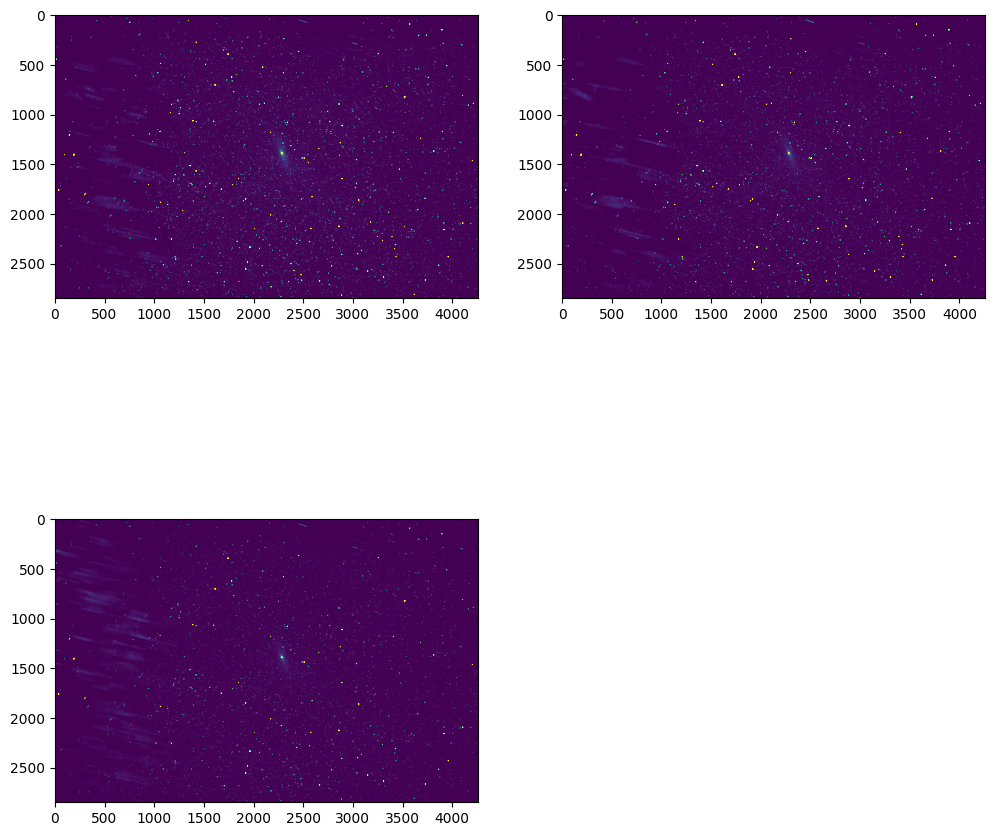

In [19]:
vmax = 200

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(coadded_g[aslice], vmin=0, vmax=vmax)
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded_b[aslice], vmin=0, vmax=vmax)
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(coadded_r[aslice], vmin=0, vmax=vmax)

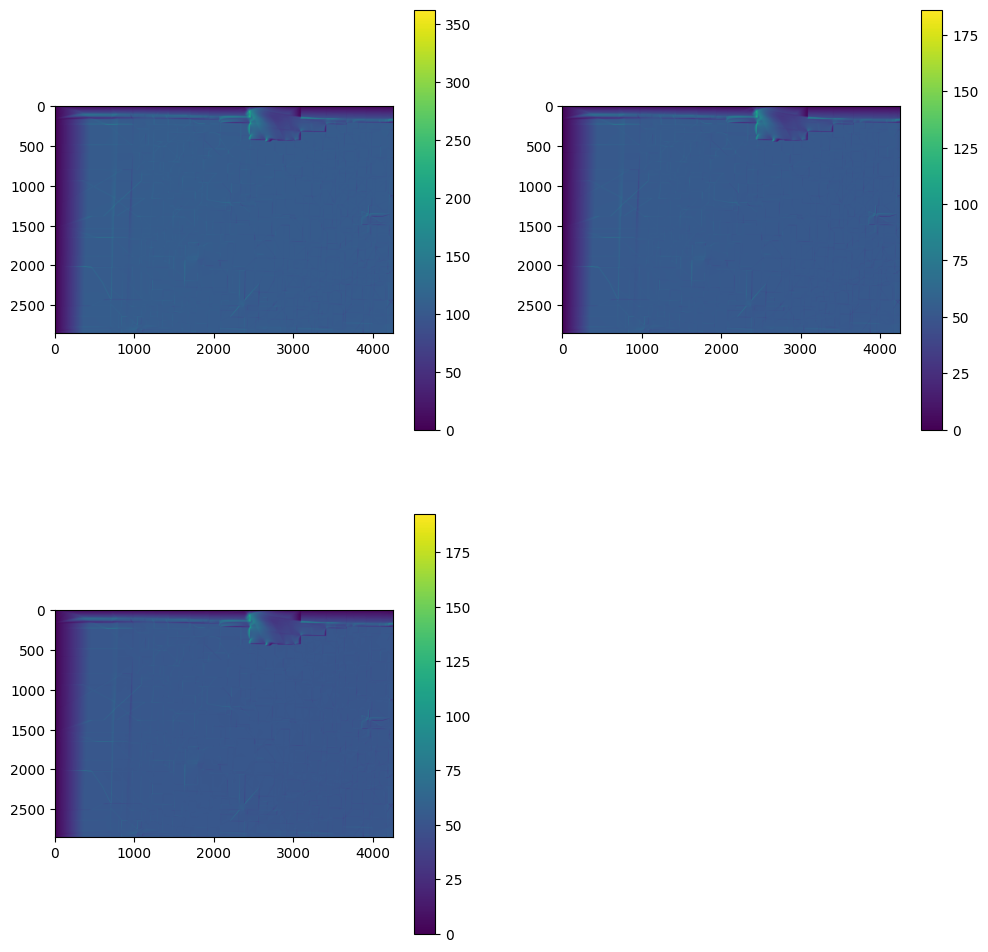

In [20]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(output_counts[1][aslice])
plt.colorbar()
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_counts[2][aslice])
plt.colorbar()
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(output_counts[0][aslice])
plt.colorbar()

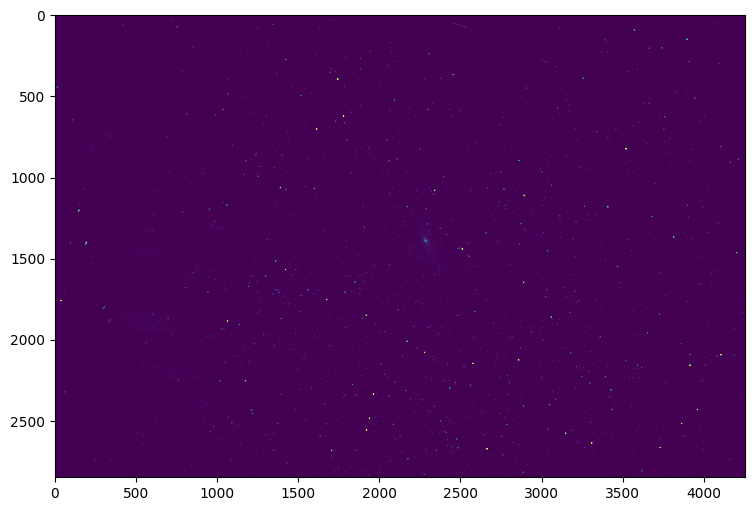

In [21]:
test_image = coadded_r * 1.93 + coadded_g + coadded_b * 1.90

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test_image[aslice], vmin=0, vmax=5000)

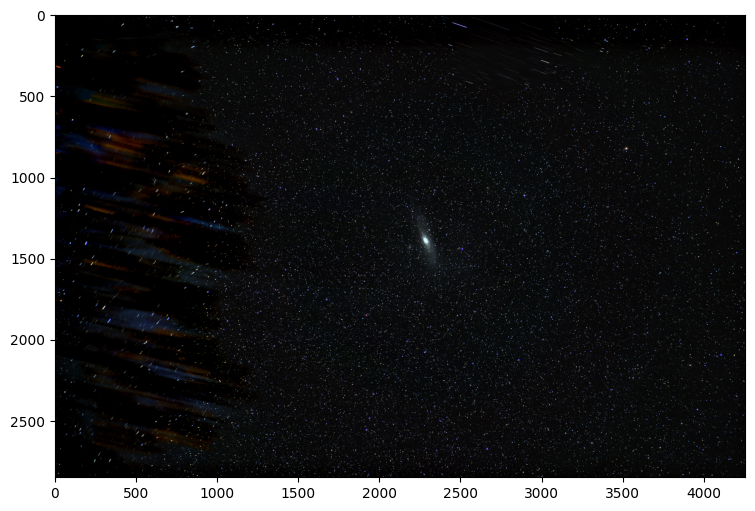

In [22]:
rgb_image = make_lupton_rgb(coadded_r * 1.5, coadded_g, coadded_b * 1.5, Q=1., stretch=150., minimum=-5.)

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image[aslice])

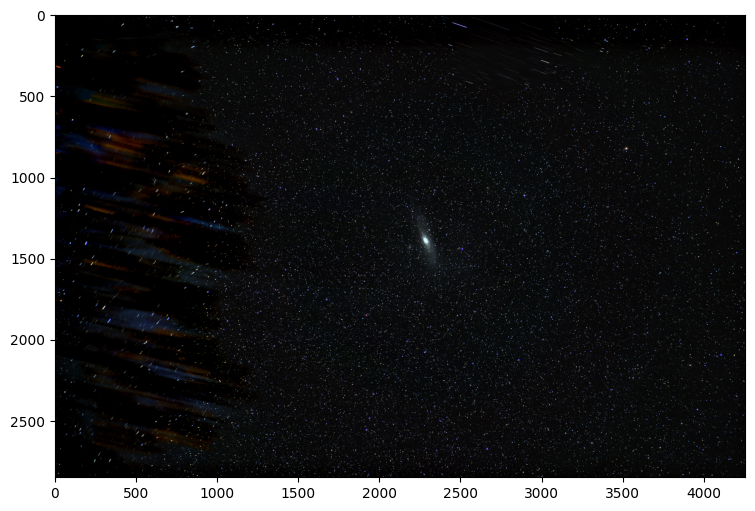

In [23]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image)

In [24]:
rgb_image.shape

(2848, 4256, 3)

In [25]:
plt.imsave("drizzle.tiff", rgb_image)

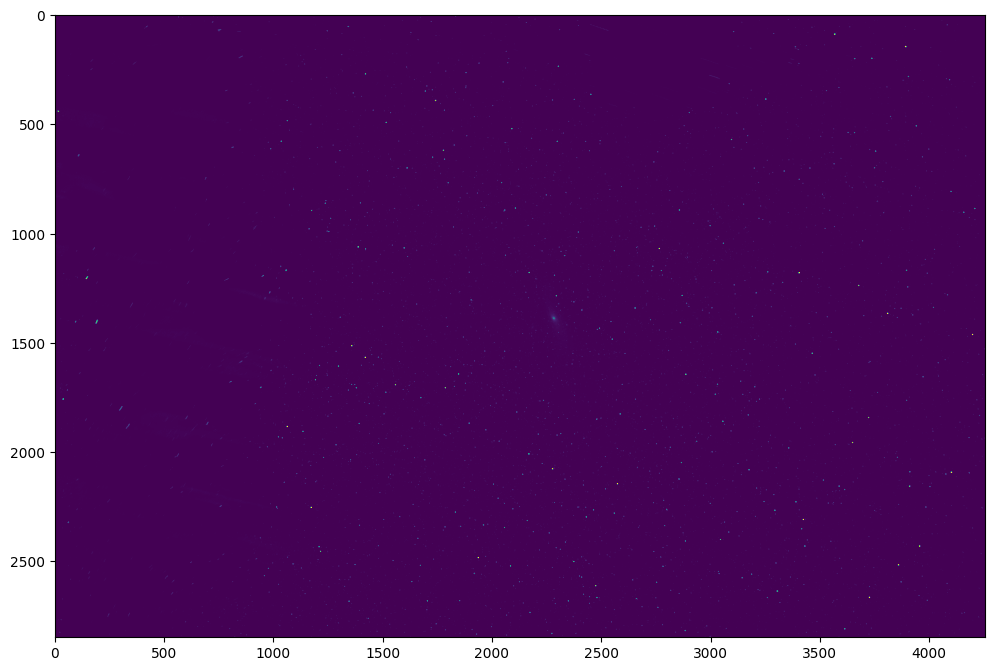

In [26]:
test = coadded_g - coadded_r

vmax = 1000

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test[aslice], vmin=0, vmax=vmax)